In [11]:
import sys, os
sys.path.append('/home/A00512318/TCN')
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from TCN.mnist_pixel.model import TCN
import numpy as np

In [12]:
# set default values for model
batch_size = 512
cuda = True
dropout = 0.05
clip = -1
epochs = 20
kernel_size = 7
levels = 8
log_interval = 100
lr = 1e-3
optimm = 'Adam'
nhid = 25
seed = 1111
permutee = False
root = '../data/fashion_mnist'
input_channels = 1
save_filename = './checkpoints/fashionmnist/fashionmnist_bst.pt'
n_classes = 10
seq_length = int(784 / input_channels)
steps = 0

In [13]:
from torchvision import datasets, transforms

def data_generator(root, batch_size):
    train_set = datasets.FashionMNIST(root=root, train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))
    test_set = datasets.FashionMNIST(root=root, train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

train_loader, test_loader = data_generator(root, batch_size)

classes = ('tshit/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle/boot')
print(classes)

('tshit/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle/boot')


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3,
        0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1,
        6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7, 9, 9, 9, 3, 2, 9, 3, 6,
        4, 1, 1, 8, 8, 0, 1, 1, 6, 8, 1, 9, 7, 8, 8, 9, 6, 6, 3, 1, 5, 4, 6, 7,
        5, 5, 9, 2, 2, 2, 7, 6, 4, 1, 8, 7, 7, 5, 4, 2, 9, 1, 7, 4, 6, 9, 7, 1,
        8, 7, 1, 2, 8, 0, 9, 1, 8, 7, 0, 5, 8, 6, 7, 2, 0, 8, 7, 1, 6, 2, 1, 9,
        6, 0, 1, 0, 5, 5, 1, 7, 0, 5, 8, 4, 0, 4, 0, 6, 6, 4, 0, 0, 4, 7, 3, 0,
        5, 8, 4, 1, 1, 2, 9, 2, 8, 5, 0, 6, 3, 4, 6, 0, 9, 1, 7, 3, 8, 5, 8, 3,
        8, 5, 2, 0, 8, 7, 0, 3, 5, 0, 6, 5, 2, 7, 5, 2, 6, 8, 2, 6, 8, 0, 4, 4,
        4, 4, 4, 1, 5, 6, 5, 3, 3, 7, 3, 3, 6, 2, 8, 4, 6, 5, 9, 3, 2, 3, 2, 4,
        4, 8, 2, 5, 3, 0, 7, 2, 0, 2, 5, 7, 2, 3, 1, 7, 6, 2, 9, 1, 9, 1, 1, 8,
        7, 8, 4, 2, 6, 6, 7, 9, 4, 6, 1,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 2, 3, 9, 8, 7, 0,
        2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 6, 5, 3, 6, 7, 1, 8,
        0, 1, 4, 2, 3, 6, 7, 2, 7, 8, 5, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 6, 7, 8,
        0, 0, 9, 9, 3, 0, 8, 4, 1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 0, 0, 0,
        1, 6, 1, 6, 2, 2, 4, 4, 1, 4, 5, 0, 4, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 7,
        4, 2, 0, 5, 2, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 6, 7, 9, 9, 4, 4, 7, 1, 2,
        1, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3,
        1, 6, 7, 2, 8, 5, 2, 0, 7, 7, 6, 2, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 4,
        5, 6, 9, 2, 6, 8, 6, 4, 2, 2, 9, 7, 6, 5, 5, 2, 8, 5, 2, 3, 0, 4, 8, 0,
        0, 6, 3, 8, 9, 6, 1, 3, 0, 2, 3, 0, 8, 3, 7, 4, 0, 1, 6, 3, 0, 6, 6, 7,
        5, 4, 5, 9, 5, 6, 5, 5, 1, 9, 8,

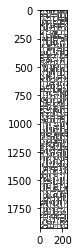

In [15]:
# sanity check for validation data
dataiter = iter(test_loader)
images, labels = dataiter.next()
print(labels)
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [23]:
# permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
channel_sizes = [nhid] * levels
# model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)
model = TCN(input_channels, n_classes, hidden_units=nhid, levels=levels, kernel_size=kernel_size, dropout=dropout)
model = nn.DataParallel(model)
model.to(device)
model.cuda()
# permute = permute.cuda()
optimizer = getattr(optim, optimm)(model.parameters(), lr=lr)

NameError: name 'nn' is not defined

In [17]:
def trainTCN(ep):
    global steps
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda: 
            data, target = data.to(device), target.to(device)
        data = data.view(-1, input_channels, seq_length)
        if permutee:
            data = data[:, :, permute]
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        if parameters[0]['clip'] > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), parameters[0]['clip'])
        optimizer.step()
        train_loss += loss.item()
        steps += seq_length
        if batch_idx > 0 and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tSteps: {}'.format(
                ep, batch_idx * parameters[0]['batch_size'], len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss/log_interval, steps))
            train_losses_[ep-1].append((train_loss/log_interval, steps))
            train_loss = 0  

In [18]:
def testTCN():
    test_loss = 0
    correct = 0
    correct_class = list(0. for i in range(10))
    correct_total = list(0. for i in range(10))
    tot = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.to(device), target.to(device)
            data = data.view(-1, input_channels, seq_length)
            if permutee:
                data = data[:, :, permute]
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            _, pred = torch.max(output, 1)
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
#             print(len(target.data.view_as(pred)))
            c = (pred == target).squeeze()
            tot += 1
#             if tot != 313:
#             for i in range(len(test_loader.dataset) // batch_size):
# #                     print(pred[i], target.data.view_as(pred)[i])
#                 print(i)
#                 label = pred[i]
#                 if (pred[i] == target.data.view_as(pred)[i]):
#                     correct_class[label] += c[i].item()
#                 correct_total[label] += 1
                    
                
#     print(tot)
#     for i in range(10):
#         print('Accuracy of %5s : %2d %%' % (
#             classes[i], 100 * correct_class[i] / correct_total[i]))

    test_loss /= len(test_loader.dataset)
#     print(correct.item())
    accuracies_.append(correct.item() / 10000.)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [19]:
def save(model):
    torch.save(model, save_filename)
    print('Saved as %s' % save_filename)

In [20]:
for epoch in range(1, epochs+1):
        trainTCN(epoch)
        testTCN()
#         if epoch % 5 == 0: 
#             print('Saving model.....')
#             save(model) 
        if epoch % 10 == 0:
            lr /= 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
save(model)

NameError: name 'model' is not defined

In [10]:
with open("./checkpoints/fashionmnist/fashionmnist_02.pt", 'rb') as f:
        model = torch.load(f)
        print(model)

TCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(1, 25, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.05)
        (conv2): Conv1d(25, 25, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.05)
        (net): Sequential(
          (0): Conv1d(1, 25, kernel_size=(7,), stride=(1,), padding=(6,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.05)
          (4): Conv1d(25, 25, kernel_size=(7,), stride=(1,), padding=(6,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.05)
        )
        (downsample): Conv1d(1, 25, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(25, 25, kernel_size=(7,), stride=(1,), padding=(12,), dilation=(2,))
        (chomp1): Chomp1d()


In [11]:
testTCN()

/home/A00512318/anaconda3/envs/tcn/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/A00512318/anaconda3/envs/tcn/lib/python3.7/site-packages/ipykernel/__main__.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Accuracy of tshit/top : 81 %
Accuracy of trouser : 98 %
Accuracy of pullover : 82 %
Accuracy of dress : 88 %
Accuracy of  coat : 81 %
Accuracy of sandal : 97 %
Accuracy of shirt : 72 %
Accuracy of sneaker : 95 %
Accuracy of   bag : 97 %
Accuracy of ankle/boot : 95 %

Test set: Average loss: 0.2943, Accuracy: 8930/10000 (89%)



tensor(0.2943, device='cuda:0')